In [1]:
#system
import sys
import os

#data processing
import numpy as np
import pandas as pd
from numpy import genfromtxt

#flow and solute transport
import flopy
from copy import deepcopy as deepcopy

#geostatistics
import gstools as gs
import skgstat as skg
from skgstat import OrdinaryKriging
from pykrige.ok import OrdinaryKriging
import statistics as stats

import scipy
from scipy.stats import gmean

#parameter--space sampling
from skopt.sampler import Lhs
import time

#GIS component
from osgeo import gdal

#plotting
# from skimage.transform import resize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

#additional plotting functionallity
import matplotlib.ticker as mtick
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Arial']})
plt.rcParams['font.size'] = 16
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.offsetbox import AnchoredText
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import RadioButtons, Slider

#version checks
print(skg.__version__)
print(gs.__version__)
print(flopy.__version__)
print(gdal.__version__)


C:\Users\willg\anaconda3\envs\GWmodel_v1\lib\site-packages\skgstat\plotting\stvariogram_plot2d.py:3: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom


1.0.1
1.3.5
3.3.4
3.4.0


### Functions

In [2]:
#3d plotting function for 2d visuals
def plot_2d(map_data, dx, dy, colorbar_label, title, cmap, clim, invert):
    # shape information
    r, c = np.shape(map_data)
    # define plot coordinates
    x_coord = np.linspace(0, dx*c, c+1)
    y_coord = np.linspace(0, dy*r, r+1)
    
    X, Y = np.meshgrid(x_coord, y_coord)

    plt.figure(figsize=(8, 4), dpi=200)
    plt.pcolormesh(X, Y, map_data, cmap=cmap, shading = 'auto', edgecolor ='k', linewidth = 0.05)
    plt.gca().set_aspect('equal')  #changed from equal
    # add a colorbar
    cbar = plt.colorbar() 
    # plt.clim(cmin, cmax) 
    # label the colorbar
    cbar.set_label(colorbar_label, fontsize = 14)
    cbar.ax.tick_params(labelsize=12) 
    plt.tick_params(axis='both', which='major', labelsize = 12)
    plt.xlim((0, dx*c)) 
    plt.ylim((0, dy*r)) 
    plt.title(title, fontsize = 14)
    plt.xlabel('x distance [m]', fontsize = 14)
    plt.ylabel('y distance [m]', fontsize = 14)
    if invert == 1:
        plt.gca().invert_yaxis()
    plt.clim(clim)
    plt.show()

In [3]:
#Slice Viewer

def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)
                
def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
#     ax.pcolormesh(volume[ax.index])
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [4]:
def geo_mean_overflow(iterable):
    return np.exp(np.log(iterable).mean())

# Importing grid and boundary conditions from QGIS
The model grid and boundary conditions are set in QGIS using:
1. 
2. 
3. 

# Setting model size and data pre-processing

In [ ]:
heads = gdal.Open('C:\\Users\\willg\\OneDrive\\Documents\\2_School\\GraduateSchool\\Fall2021\\!Research\\Geostatistics_paper\\GIS_data\\airport_boundary_raster.tif')
heads500_array = np.array(heads.GetRasterBand(1).ReadAsArray())
heads500_array = np.flip(heads500_array, axis = 0)

plt.figure(figsize=(8, 4), dpi=200)
plt.pcolormesh(heads500_array, cmap = 'Blues', vmin = np.amin(heads500_array), vmax = np.amax(heads500_array), 
               shading = 'auto', edgecolor ='k', linewidth = 0.05) #indices correspond to x,y,z
plt.gca().set_aspect('equal')
plt.colorbar()

heads500_array.shape


In [5]:
#getting ksat as an array and then rancomply sampling from the array to provide kriging points
#stacking ksat raster
# directory = 'C:\\Users\\willg\\OneDrive\\Documents\\2_School\\GraduateSchool\\Fall2021\\!Research\\Geostatistics_paper\\ModelData'
# d = {}
# for x in range(1, 10):
#     d["string{0}".format(x)] = "Hello"

#buid this into a loop
ksat10_raster = gdal.Open('C:\\Users\\willg\\OneDrive\\Documents\\2_School\\GraduateSchool\\Fall2021\\!Research\\Geostatistics_paper\\ModelData\\ksat10.tif')
ksat10_array = np.array(ksat10_raster.GetRasterBand(1).ReadAsArray())

ksat20_raster = gdal.Open('C:\\Users\\willg\\OneDrive\\Documents\\2_School\\GraduateSchool\\Fall2021\\!Research\\Geostatistics_paper\\ModelData\\ksat20.tif')
ksat20_array = np.array(ksat20_raster.GetRasterBand(1).ReadAsArray())

ksat30_raster = gdal.Open('C:\\Users\\willg\\OneDrive\\Documents\\2_School\\GraduateSchool\\Fall2021\\!Research\\Geostatistics_paper\\ModelData\\ksat30.tif')
ksat30_array = np.array(ksat30_raster.GetRasterBand(1).ReadAsArray())

ksat40_raster = gdal.Open('C:\\Users\\willg\\OneDrive\\Documents\\2_School\\GraduateSchool\\Fall2021\\!Research\\Geostatistics_paper\\ModelData\\ksat40.tif')
ksat40_array = np.array(ksat40_raster.GetRasterBand(1).ReadAsArray())

ksat50_raster = gdal.Open('C:\\Users\\willg\\OneDrive\\Documents\\2_School\\GraduateSchool\\Fall2021\\!Research\\Geostatistics_paper\\ModelData\\ksat50.tif')
ksat50_array = np.array(ksat50_raster.GetRasterBand(1).ReadAsArray())

ksat60_raster = gdal.Open('C:\\Users\\willg\\OneDrive\\Documents\\2_School\\GraduateSchool\\Fall2021\\!Research\\Geostatistics_paper\\ModelData\\ksat60.tif')
ksat60_array = np.array(ksat60_raster.GetRasterBand(1).ReadAsArray())

ksat70_raster = gdal.Open('C:\\Users\\willg\\OneDrive\\Documents\\2_School\\GraduateSchool\\Fall2021\\!Research\\Geostatistics_paper\\ModelData\\ksat70.tif')
ksat70_array = np.array(ksat70_raster.GetRasterBand(1).ReadAsArray())

ksat80_raster = gdal.Open('C:\\Users\\willg\\OneDrive\\Documents\\2_School\\GraduateSchool\\Fall2021\\!Research\\Geostatistics_paper\\ModelData\\ksat80.tif')
ksat80_array = np.array(ksat80_raster.GetRasterBand(1).ReadAsArray())

ksat90_raster = gdal.Open('C:\\Users\\willg\\OneDrive\\Documents\\2_School\\GraduateSchool\\Fall2021\\!Research\\Geostatistics_paper\\ModelData\\ksat90.tif')
ksat90_array = np.array(ksat90_raster.GetRasterBand(1).ReadAsArray())

ksat100_raster = gdal.Open('C:\\Users\\willg\\OneDrive\\Documents\\2_School\\GraduateSchool\\Fall2021\\!Research\\Geostatistics_paper\\ModelData\\ksat100.tif')
ksat100_array = np.array(ksat100_raster.GetRasterBand(1).ReadAsArray())

#creating the cube
ksat_cube = np.stack((ksat10_array, ksat20_array, ksat30_array, ksat40_array, ksat50_array, 
                      ksat60_array, ksat70_array, ksat80_array, ksat90_array, ksat100_array,), axis=-1)

ksat_cube_mday = np.multiply(ksat_cube, 0.0864) #conversion to m/day
ksat_cube_test = np.where(ksat_cube_mday==0, 0.5, ksat_cube_mday) 
ksat_cube_test.shape


(74, 97, 10)

Text(0.5, 1.0, 'plan-view')

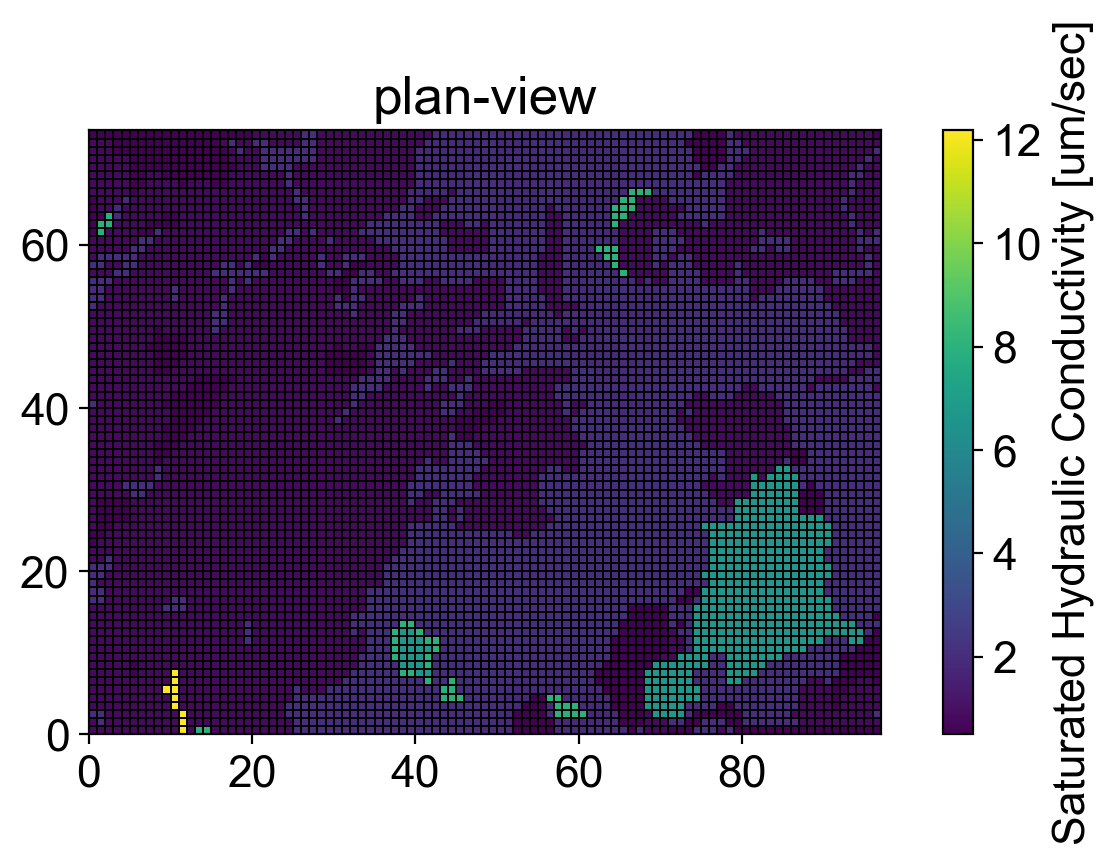

In [6]:
#visualizing the cube
plt.figure(figsize=(8, 4), dpi=200)
plt.pcolormesh(ksat_cube_test[:,:,7], cmap = 'viridis',shading = 'auto', edgecolor ='k', linewidth = 0.05) #indices correspond to x,y,z
plt.gca().set_aspect('equal')
plt.colorbar(label = 'Saturated Hydraulic Conductivity [um/sec]')
plt.title('plan-view')
# plt.pcolormesh(ksat_cube[:,10,:], cmap = 'viridis',shading = 'auto', edgecolor ='k', linewidth = 0.05) #indices correspond to x,y,z
#test = ksat_cube.flatten()
# print(test)

In [68]:
#attempt to convert raster array back to x,y,z,value columns
ksat_cube_coord = []
for x in range(len(ksat_cube_test)):
    for y in range(len(ksat_cube_test[x])):
        for z in range(len(ksat_cube_test[x][y])):
            ksat_cube_coord.append(
            {
                'xcoord': x,
                'ycoord': y,
                'zcoord': z,
                'value': ksat_cube_test[x,y,z]
            }
            )


In [71]:
# coords.shape
ksat_cube_df = pd.DataFrame(ksat_cube_coord)

,xcoord,ycoord,zcoord,value
19743,20,34,3,0.792288
25222,26,0,2,0.777600
68644,70,74,4,0.500000
70929,73,11,9,0.500000
56177,57,88,7,0.792288
...,...,...,...,...
50103,51,63,3,1.900800
41865,43,15,5,0.500000
67143,69,21,3,1.987200
53481,55,13,1,0.792288


In [ ]:
# 3 dimensional model size
# nlay = 10 # will change with added info
# ncol = 97
# nrow = 74

# print('Model size: ' + str(nlay) +' layers, ' + str(nrow)+' rows, ' + str(ncol) + ' columns')

# z = np.arange(nlay)
# y = np.arange(nrow)
# z = np.arange(ncol)

# print(z)

In [ ]:
#randomly sampled conditional kriging GIS data
#500 randomly sampled points across model boundary (Each point contains full depth profile)
airprt_params = pd.read_csv('C:\\Users\\willg\\OneDrive\\Documents\\2_School\\GraduateSchool\\Fall2021\\!Research\\Geostatistics_paper\\ModelData\\Airport_modelParams.csv' )
# airprt_params.head()
# airprt_params = airprt_params.loc[airprt_params['ksat mday'] == '0.0', 'ksat_mday'] = 0.5

#randomly sampling 100 points
airport_params_sample =  airprt_params.sample(n = 200)
airport_params_array = airport_params_sample.to_numpy()

x_cond = airport_params_array[:,0]
y_cond = airport_params_array[:,1]
z_cond = airport_params_array[:,2]
ksat = airport_params_array[:,5] #m/day


In [ ]:
#conditional kriging -- measured data
loc = np.arange(['B004', 'B004', 'B004', 'B005', 'B005', 'B006', 'B006', 'B006'])
depth = np.arange(['1', '7', '13', '8', '14', '3', '9', '13']) #feet
layer = np.arange([1, 6, 10, 8, 10, 3, 9, 10])
hyd_cond = np.arange(['10.454', '12.442', '1.058', '14.602', '14.602', '2.906', '24.970', '18.1656']) #m/day

# Defining the Parameter Space using Latin HyperCube

In [72]:
#generating the 'geologic structure' of the model
lhs = Lhs(lhs_type="classic", criterion=None)

In [73]:
#Parameters Ps[0-...]
#Ps[0] = log variance
#Ps[1,2,3] = correlation length x,y,z
#Ps[4,5,6] = rotation angles + an angle tolerance of BLANK degrees -- specify in angle_tol
#Ps[7, 8] = anisotropy

#last number of samples
num_samps = 20
angle_tol = 22.5
Ps = lhs.generate([(-1, 1.5),
                   (1.0, 10.0), (5.0, 40.0), (1.0, 5.0),
                   (np.deg2rad(45-angle_tol), np.deg2rad(45+angle_tol)), 
                   (np.deg2rad(135-angle_tol), np.deg2rad(135+angle_tol)), 
                   (np.deg2rad(0), np.deg2rad(90)),
                   (2, 5), (0.2, 1.5)], 
                  num_samps)


C:\Users\willg\anaconda3\envs\GWmodel_v1\lib\site-packages\skopt\space\transformers.py:275: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.round(X_orig).astype(np.int)


### Realizations

In [ ]:
#generate the full ensample realizations and save the fields

#need to save the resulting fields into a dictionary
%matplotlib qt
start_td = time.time() # start a timer

for i in range(0, 2):
    p = Ps[i]
    
    model = gs.Exponential(dim=3, 
                           var=10**p[0], 
                           len_scale=[p[1], p[2], p[3]], 
                           nugget = 0,
                           anis = p[7],
                           angles=[p[4], p[5], p[6]],
                           integral_scale = None,
                           rescale=None,
                           latlon=False,
                           var_raw=None,
                           hankel_kw=None,
#                            **opt_arg,
                          )
    
    srf = gs.SRF(model)#, seed=20170519)
    
    field = srf.structured([x, y, z])
    
    #kriging measured ksat data points
    
    
    end_td = time.time() # end timer
    print('Sec to run generate field: ', (end_td - start_td)) # show run time
#     print((np.max(field)/np.min(field)))

    #plotting
#     fig, ax = plt.subplots(1, 2, figsize=[10, 5], gridspec_kw={'width_ratios': [2, 1]})
    
#     ax[0].figure(figsize=(5, 4), dpi=200)
#     ax[0].pcolormesh(field[:, :, 0])
#     ax[0].set_aspect('equal')
#     ax[0].set_xlabel('x')
#     ax[0].set_ylabel('y')
    
#     cbar = ax[0].colorbar()
#     cbar.set_label('mD')
    
#     ax[1].figure(figsize=(5, 4), dpi=200)
#     im = ax[1].pcolormesh(field[0, :, :])
#     ax[1].set_aspect('equal')
#     ax[1].set_xlabel('z')
    
#     fig.subplots_adjust(right=0.8)
#     cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#     cbar = fig.colorbar(im, cax=cbar_ax)
#     cbar.set_label('variance')
    
#     divider = make_axes_locatable(ax[1])
#     cax = divider.append_axes("bottom", size = '5%', pad=0.05)
#     cbar = fig.colorbar(im, ax=ax[1], cax=cax)
#     cbar.set_label('variance')


# Plotting

In [74]:
z = range(30)
y = range(97)
x = range(74)

In [ ]:
#kriging params - randomly sample 50 points from the ksat soil array
# A = np.random.randint(5, size=(10,3))

In [129]:
#new plotting attempt on one field --- generate one field
# %matplotlib qt

p = Ps[19]   
model = gs.Exponential(dim=3, 
                        var=10**p[0], 
                        len_scale=[p[1], p[2], p[3]], 
                        nugget = 0,
                        anis = [p[7], p[8]],
                        angles=[p[4], p[5], p[6]],
                        integral_scale = None,
                        rescale=None,
                        latlon=False,
                        var_raw=None,
                        hankel_kw=None)
    
srf = gs.SRF(model)#, seed=20170519)
    
field = srf.structured([x, y, z])

#kriging
# cond_pos = randomly sampled points
# cond_pos = np.array([[20, 13, 40, 12, 16, 19, 30, 20], [25, 40, 15, 19, 5, 30, 1, 37], [1, 6, 10, 8, 10, 3, 9, 10]]) #xyz
# cond_val = np.array([10.454, 12.442, 1.058, 14.602, 14.602, 2.906, 24.970, 18.1656]) #m/day

#every realization get a new set of random samples from the original 500
#!!!!!!!in the future jut sample from the raster!!!!!!!!!!!
ksat_sample =  ksat_cube_df.sample(n = 150)
ksat_sample_array = ksat_sample.to_numpy()

x_cond = ksat_sample_array[:,0]
y_cond = ksat_sample_array[:,1]
z_cond = ksat_sample_array[:,2]
ksat   = ksat_sample_array[:,3] #m/day

#randomly sample 100 points and get the ksat values...
cond_pos = np.array((x_cond, y_cond, z_cond)) #xyz
cond_val = ksat #m/day

krige = gs.Krige(model, cond_pos=cond_pos, cond_val=cond_val)
cond_srf = gs.CondSRF(krige, seed = 48753)
field_cond = (cond_srf.structured([x, y, z]))

# field.shape
#field summary - conditioned values
# print('max ', max(cond_val))
# print('median ', stats.median(cond_val))
# print('mean ', stats.mean(cond_val))
# print('min ', min(cond_val))

In [131]:
#quick visuals
%matplotlib qt

#Plan-View of condition-kriged random field====================================================================================
plot_layer = 2
plt.figure(figsize=(8, 4), dpi=200)
plt.pcolormesh(field_cond[:, :, plot_layer], cmap = 'viridis', shading = 'auto')#, edgecolor ='face', linewidth = 0.05)

#filter data to plot_layer -- scatter plot of kriging values
ksat_depth_filter = ksat_sample[ksat_sample['zcoord'] == plot_layer]
plt.scatter(ksat_depth_filter['ycoord'], ksat_depth_filter['xcoord'], c = ksat_depth_filter['value'], s = 25, edgecolors = 'k')
#finish plot
plt.gca().set_aspect('equal')
plt.colorbar(label = 'kSat [m/day]')
plt.title('Conditionally-Kriged SRF: plan-view (nlay: {})'.format(plot_layer))

#depth profile of condition-kriged random field===============================================================================
# plot_row = 20
# plt.figure(figsize=(4, 8), dpi=200)
# plt.pcolormesh(field_cond[plot_row,:,:], cmap = 'viridis', shading = 'auto')#, edgecolor ='face', linewidth = 0.05)
# #filter row of interest
# ksat_row_filter = ksat_sample[ksat_sample['ycoord'] == plot_row]
# # plt.scatter(max(ksat_sample['xcoord'])-ksat_depth_filter['xcoord'], max(ksat_sample['ycoord'])-ksat_depth_filter['ycoord'])
# plt.scatter(ksat_row_filter['xcoord'], ksat_row_filter['zcoord'], c = ksat_row_filter['value'], s = 25, edgecolors = 'k')
# #finish plot
# plt.gca().set_aspect('equal')
# plt.colorbar(label = 'Saturated Hydraulic Conductivity [m/day]')
# plt.title('depth profile')

#Looking at field inputs
print("Model Parameters:")
print("Variance:", round(model.var, 3))
print("Anis. ratios:", model.anis)
print("Main length scale:", model.len_scale)
print("All length scales (xyz):", model.len_scale_vec)
print("Rotation angles (xyz):", model.angles)

# print('Field Geometric Mean: ', round(geo_mean_overflow(field_cond), 3))
# print('Variance: ', round(10**p[0], 3))
# print('Correlation length scales (xyz): ', round(p[1], 3), round(p[2], 3), round(p[3], 3))
# print('Rotation directions (xyz): ', round(p[4], 3), round(p[5], 3), round(p[6], 3))
# print('Anisotropy: ', round(p[7], 3), round(p[8],3))


Model Parameters:
Variance: 0.467
Anis. ratios: [5.113045  1.2748369]
Main length scale: 2.339253145831498
All length scales (xyz): [ 2.33925315 11.9607066   2.98216622]
Rotation angles (xyz): [0.67887757 2.39141311 1.07311075]


In [ ]:
#looking at anisotropy
model.plot("vario_spatial")

In [ ]:
#multislice for some reason the axes are always jank...
%matplotlib qt
fig1 = multi_slice_viewer(field_cond.T) #xy
# fig2 = multi_slice_viewer(field) #y+depth

In [ ]:
fig2 = multi_slice_viewer(ksat_cube.T)

In [58]:
def normalize(field):
    field_min = np.min(field)
    return (field-field_min)/(np.max(field)-field_min)

def show_histogram(values):
    n, bins, patches = plt.hist(values.reshape(-1), 50, density=True)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for c, p in zip(normalize(bin_centers), patches):
        plt.setp(p, 'facecolor', cm.viridis(c))

    plt.show()
    
show_histogram(field_cond)

NameError: name 'field_cond' is not defined

In [59]:
from mpl_toolkits.mplot3d import Axes3D
def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

In [63]:
def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def plot_cube(cube, angle=320):
    cube = normalize(cube)
    
    facecolors = cm.viridis(cube)
    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)
    
    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(30/2.54, 30/2.54))
    ax = fig.gca(projection='3d')
    ax.view_init(30, angle)
    ax.set_xlim(right=field.shape[0]*2) #field needs to be the entire size not the input cube size
    ax.set_ylim(top=field.shape[1]*2)
    ax.set_zlim(top=field.shape[2]*2)
    ax.set_title('Realization Cross-section')
    
    ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)
    plt.show()
  

In [ ]:
# plot_cube(field[::-1,::-1,::-1]) #plot entire cube
plot_cube(field_cond[:37,::-1,::-1]) #x,y,z


C:\Users\willg\AppData\Local\Temp\ipykernel_6732\2159157707.py:26: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


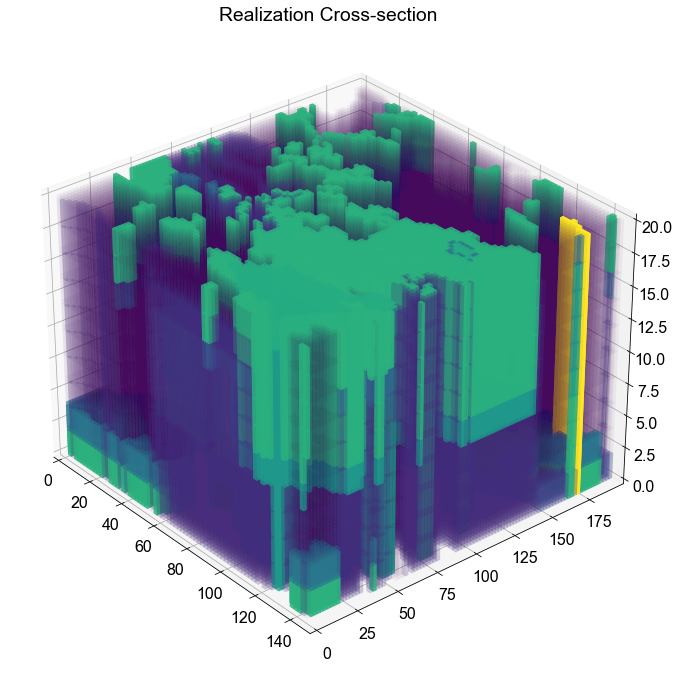

In [65]:
#plot ksat raster
plot_cube(ksat_cube_test[::-1, ::-1, ::-1])

In [ ]:
cube = np.copy(field_cond)

for x in range(0, field.shape[0]):
    for y in range(0, field.shape[1]):
        for z in range(max(x-y+5, 0), field.shape[2]):
            cube[x, y, z] = 0
plot_cube(cube, angle=200)